# Application of Inverse RL algorithm on Mountain Car env:

This code is an application of IRL algorithm on Mountain Car environment in the case:
1. Where the dynamics of the environment are not known to the agent. (No transition probabilities)
2. The agent uses expert trajectories data to learn the "Reward Function".
For  more details on the algorithm, refer to Case 3 of [Algorithms for Inverse Reinforcement Learning](https://ai.stanford.edu/~ang/papers/icml00-irl.pdf) paper.

## Mountain Car Environment:
###  Properties:
1. Continuous State Space Environment.
    - state = [position/pos, velocity/vel]
    - pos.min_position = -1.2
    - pos.max_position = 0.6
    - vel.max_speed = 0.07
    - env.goal_position = 0.5


2. Discrete Action Space
    - self.action_space = spaces.Discrete(3)
    - Implies it has three actions.
    - 0- accelerates in the left direction
    - 1 - zero acceleration 
    - 2- accelerates in the right direction
    - acceleration= 0.001 units

###  Function Approximators:
1. Linear Function Approximators are used for the RL and IRL code blocks instead of neural networks.

# Code

In [1]:
%matplotlib inline

import gym
import itertools
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import sklearn.pipeline
import sklearn.preprocessing
from sklearn.kernel_approximation import RBFSampler
from collections import defaultdict
import scipy
from q_learning import *
from datetime import datetime
import warnings

warnings.filterwarnings('ignore')

In [2]:
def normalization(env,observation_examples):
    """
    Calculates Mean and Variance of the state values
    
    Args:
        observation_examples: An array of 10000 random state::[position, velocity] values.
    Returns:
        Mean and variance of the state values.
    """
    scaler = sklearn.preprocessing.StandardScaler()
    scaler.fit(observation_examples)
    return scaler

In [3]:
def featurizer_function(normalized_data, featureVecDim):
    """
    Calculates Mean and Variance of the state values
    
    Args:
        normalized_data: An array of 10000 normalized state::[position, velocity] values.
        featureVecDim: Dimension of ϕ vector.(feature vector/Basis vector)
    Returns:
        Container for ϕ vector.
    """
    # Container for ϕ vector(Basis vector).[In the paper, they used 26 evenly spaced Gaussian shaped basis functions]
    featurizer_vector = sklearn.pipeline.FeatureUnion([
        ("rbf1",RBFSampler(gamma=0.5,n_components=10)),
        ("rbf2", RBFSampler(gamma=0.25, n_components=20)),
        ("rbf3", RBFSampler(gamma=0.1, n_components=20))
    ])
    
    # Reward dependency on position value only.
    position_vec = np.delete(normalized_data, 1,1)
    # Fit method defines the upper and lower limits of random offset and fits the data
    featurizer_vector.fit(position_vec)
    
    return featurizer_vector

In [4]:
def scaler_val(state,scaler):
    return (state[0]- scaler.mean_[0])/scaler.var_[0]

In [5]:
def UniformRandomPolicyGenerator(nA):
    # nA = number of actions
    def urpg(state):
        return np.ones(nA, dtype=float)/nA
    return urpg

In [6]:
def RandomVectorGenerator(featureVecDim):
    return 2*np.random.rand(featureVecDim)-1

In [7]:
def max_dict(dictionary):
    v_max=max(dictionary.values())
    for key, value in dictionary.items():
        if value == v_max:
            return key

In [8]:
def e_greedy_policy(estimator, nA, epsilon):
    def policy_maker(observation):
        A = np.ones(nA, dtype=float) * epsilon / nA
        q_values = estimator.predict(observation)
        best_action = np.argmax(q_values)
        A[best_action] += (1.0 - epsilon)
        return A
    return policy_maker


In [9]:
def reward(alpha_vec, featurizer_vector, scaler):
    def reward_fn(state):
        position = state[0]  # Lấy vị trí
        velocity = state[1]  # Lấy vận tốc
        # Tính phần thưởng theo cách thức bạn muốn (phần thưởng cao khi xe gần đáy)
        # Ví dụ: Khuyến khích xe ở gần vị trí thấp (-1.2) càng lâu càng tốt
        return -abs(position + 1.2)  # Phần thưởng cao khi xe gần vị trí thấp nhất (-1.2)
    return reward_fn


In [10]:
def reward_plot(alpha_vec, featurizer_vector, scaler, save=False):
    x = np.linspace(-1.2, 0.6, num=1000)
    y = np.zeros(1000)

    for i, position in enumerate(x):
        normalized_position = (position - scaler.mean_[0]) / scaler.var_[0]
        y[i] = np.dot(alpha_vec, featurizer_vector.transform([[normalized_position]])[0])

    plt.plot(x, y, linewidth=2.0)
    plt.xlabel("Position")
    plt.ylabel("Reward")
    plt.title("Reward function")

    if save:
        current_time = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
        filename = f"mountain_car_{current_time}.png"
        plt.savefig(filename)
        print(f"Plot saved as {filename}")

    plt.show()

In [11]:
"""
Some experiments were done to smoothen up the alpha vector, if somebody would like to try.
I got some results,of them some were good but it resulted in diverging solutions many times.
"""
def smooth(y, box_pts=4):
    box = np.ones(box_pts)/box_pts
    y_smooth = np.convolve(y, box, mode='same')
    return y_smooth

def savitzky_golay(y, window_size=51, order=5, deriv=0, rate=1):

    import numpy as np
    from math import factorial
    try:
        window_size = np.abs(np.int(window_size))
        order = np.abs(np.int(order))
    except ValueError:
        raise ValueError("window_size and order have to be of type int")
    if window_size % 2 != 1 or window_size < 1:
        raise TypeError("window_size size must be a positive odd number")
    if window_size < order + 2:
        raise TypeError("window_size is too small for the polynomials order")
    order_range = range(order+1)
    half_window = (window_size -1) // 2
    # precompute coefficients
    b = np.mat([[k**i for i in order_range] for k in range(-half_window, half_window+1)])
    m = np.linalg.pinv(b).A[deriv] * rate**deriv * factorial(deriv)
    # pad the signal at the extremes with
    # values taken from the signal itself
    firstvals = y[0] - np.abs( y[1:half_window+1][::-1] - y[0] )
    lastvals = y[-1] + np.abs(y[-half_window-1:-1][::-1] - y[-1])
    y = np.concatenate((firstvals, y, lastvals))
    return np.convolve( m[::-1], y, mode='valid')

In [12]:
def ValueFunctionGenerator(env,alpha_vec, policy,featurizer_vec,scaler,featureVecDim, num_trajectories,discount_factor):
    """
    Calculates the value and value vector of the start state: V(𝚜0).
    
    Args:
        env: Gym environment
        alpha_vec: The alpha vector (variable) to be learnt.
        policy: Given a state, it provides the probabilities of each possible action.{π[𝚊i|s]}
        featurizer_vec: The container for basis fuctions.(RBF kernals in this case)
        scaler: Mean and variance of the state values.
        featureVecDim: Dimension of ϕ vector.(feature vector/Basis vector)
        num_trajectories: Expert trajectories taken under consideration
    
    Returns:
        Value of the start state V(𝚜0):R(τ)= [α0 α1 .. αn]⋅[𝚅ϕ0 𝚅ϕ1 .. 𝚅ϕn]
        Value vector: [𝚅ϕ0 𝚅ϕ1 ... 𝚅ϕn] where ϕi represents basis functions of feature vector
    
    """
    v_basis= np.zeros(featureVecDim)
    episode = defaultdict(list) 
    for i in range(num_trajectories):
        state= reset_environment(env)
        done =False
        for l in range(200):    
            prob = policy(state)
            action = np.random.choice(np.arange(len(prob)),p=prob)
            new_observations = env.step(action)
            next_state = new_observations[0]
            done = new_observations[2]
            if done == True:
                break
            episode[i].append((state,action))
            state = next_state
            l+=1
        env.close()
        j=0
        for state, action in episode[i]:
            v_basis += featurizer_vec.transform([[scaler_val(state,scaler)]])[0]* (discount_factor)**j 
            j+=1
        
    
    v_basis_net = v_basis/num_trajectories
    V= np.dot(alpha_vec,v_basis_net)
    return V , v_basis_net

In [13]:
def irl(env, alpha_vec,featurizer_vector, scaler, featurizer, normalized_data, featureVecDim, policy_dbe,num_trajectories=10, num_episodes=20, max_epoch=10, discount_factor=1, penalty_factor=2, epsilon_v=0.0):
    """
    The algorithm to learn a reward function given expert policy/trajectories.
    
    Args:
        env: Gym environment
        alpha_vec: The alpha vector (variable) to be learnt.
        featurizer_vector: The container for basis fuctions(RBF kernals in this case).
        scaler: Mean and variance of the state values.
        featurizer: The container used for generating expert trajectories.
        normalized_data: An array of 10000 normalized state::[position, velocity] values.
        featureVecDim: Dimension of ϕ vector.(feature vector/Basis vector)
        policy_dbe: "Demostration by expert" policy.==Expert policy
        num_trajectories: Expert trajectories taken under consideration
        num_episodes: Number of episodes for which the RL code is run. 
        max_iter: Maximum number of episodes
        penalty_factor: Refer the paper for more details
        epsilon_v: ϵ value for Epsilon greedy policy
        
    Returns:
        Reward Function R(s).
        Alpha Vector: α = [α0 α1 .. αn]
    """
    # Initializing Variables
    nP=0                                    # number of epochs
    V_vec = defaultdict(float)
    V_policy_basis = defaultdict(list)
    V_input = np.zeros(featureVecDim)
    
    # Calculating V* value for the best DBE policy that we already have.
    V_dbe, V_dbe_basis = ValueFunctionGenerator(env,alpha_vec, policy_dbe,featurizer_vector,scaler,featureVecDim, num_trajectories, discount_factor)
    print("-------------------------------")
    print("| V_dbe | ",V_dbe," |")
    print("-------------------------------")
    print("")
    
    # Iterating part of the code : new learnt policy with each new iteration
    
    while True:
        print("############################################################################")
        print("Starting epoch {} .... ".format(nP))
        print("Alpha_vec value at the start of the epoch = {}".format(alpha_vec)) 
        
        # Uniform Random policy
        if nP ==0:
            policy_ = UniformRandomPolicyGenerator(env.action_space.n)
        
        V_vec[nP], V_policy_basis[nP] = ValueFunctionGenerator(env,alpha_vec, policy_,featurizer_vector,scaler,featureVecDim,num_trajectories, discount_factor)
        print("New policy value based on previous alpha, V_vec[np] = {}".format(V_vec[nP]))
    
    
        # Linear Programming optimization
        print("_____________________________LP starts_______________________________")
        
        # nP_best: Iteration with the max value according to the present alpha_vec.
        nP_best = max_dict(V_vec)
        
        print("nP_best =", nP_best)
        print("nP_best_value based on old alpha =", V_vec[nP_best])
        print("DBE_value based on old alpha =", V_dbe)
        
        if V_dbe - V_vec[nP] >= 0:
            V_input += V_policy_basis[nP] - V_dbe_basis
        else:
            V_input += penalty_factor* (V_policy_basis[nP] - V_dbe_basis)
        
        res = scipy.optimize.linprog(V_input, bounds=(-1,1), method="simplex")
        
        print("**********LP results******************************************************")
        print("                       ")
        #print(res)
        print("new alpha_vec = ", res.x)
        print("                       ")
        print("**************************************************************************")
        
        alpha_vec_new = res.x
        
        # New V-dbe value based on new alpha
        V_dbe_new = np.dot(alpha_vec_new,V_dbe_basis)
        
        # Updating old values with new values
        alpha_vec = alpha_vec_new
        V_dbe = V_dbe_new
        
        # Editing v_vec values based on new alpha
        for i,list_ in V_policy_basis.items():
            V_vec[i] = np.dot(list_,alpha_vec)
        
        print("According to new alpha, V_dbe = ", V_dbe_new)
        print("New V_vec[max] in existing values", V_vec[max_dict(V_vec)])
        print("_________________________________________________________________________")
        print("Plotting reward function based on alpha_vec start value.....")
        
        reward_plot(alpha_vec, featurizer_vector,scaler)

        # Reinforcement learning using the learnt reward function to generate new policy
        
        print("Q learning starts..........")
        # Given the new alpha_vec, update the rewards function and find a new policy
        reward_fn = reward(alpha_vec,featurizer_vector,scaler)
        nP +=1
        
        estimator = Estimator(env,scaler,featurizer)
        min_iter_length = q_learning(env, estimator, reward_fn, num_episodes,print_ep_details=False) 
        policy_ = e_greedy_policy(estimator, env.action_space.n,epsilon_v)
        """
        ** For printing iterations with number of timesteps it took, set 
        {print_ep_details=True} in q_learning().Highly Suggested for starting analysis.
        """
    
        if nP > max_epoch:
            break
        print("############################################################################")
    
    
    return reward_fn, alpha_vec

In [14]:
# Đặt xe xuất phát tại đỉnh đồi
def reset_environment(env):
    """Khởi tạo môi trường MountainCar để xe xuất phát từ đỉnh đồi."""
    state = env.reset()
    # Đỉnh đồi nằm ở vị trí 0.5 với vận tốc bằng 0
    env.state = [0.5, 0.0]
    return env.state


Random Alpha Vector: 
[-0.6110275   0.96090328  0.27444385  0.65464446 -0.54417831  0.22657379
  0.4035276   0.59970366 -0.59093717  0.77183592  0.64940425 -0.08421463
 -0.58583441 -0.37701535 -0.30296147 -0.7728647   0.91103136  0.85177588
  0.40415365 -0.89076107 -0.01804672 -0.88841731 -0.31666092  0.96085172
  0.31011928 -0.01056733  0.83946016  0.72317059  0.99973906 -0.90236129
  0.64502055  0.37530838 -0.37330272  0.23464807 -0.03343216  0.35293516
 -0.02514123  0.44814551 -0.90459175 -0.43070376 -0.89439736 -0.06503649
 -0.67261296 -0.99189463 -0.05104322  0.33242124  0.01293635 -0.03059213
 -0.63614147  0.86954373]

____Expert Policy Generation____

** For printing iterations with number of timesteps it took, set {print_ep_lens=True}.Highly Suggested for starting analysis.


100%|██████████| 200/200 [02:43<00:00,  1.22it/s]

___Plotting Learning Stats of the Agent____


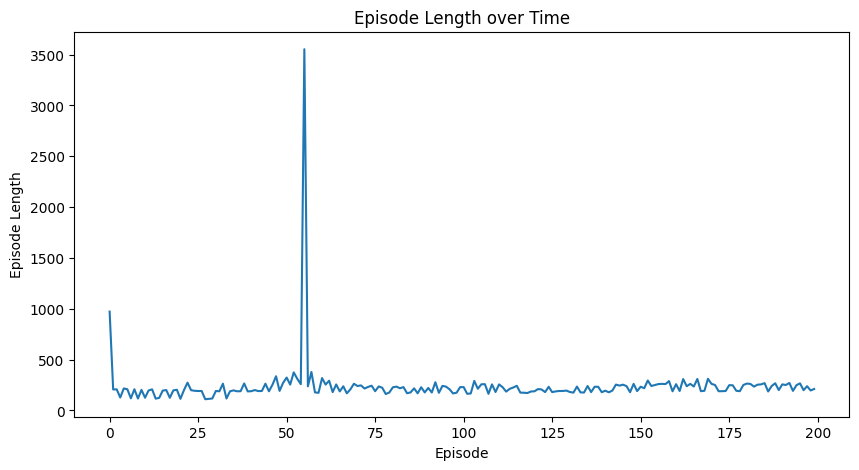

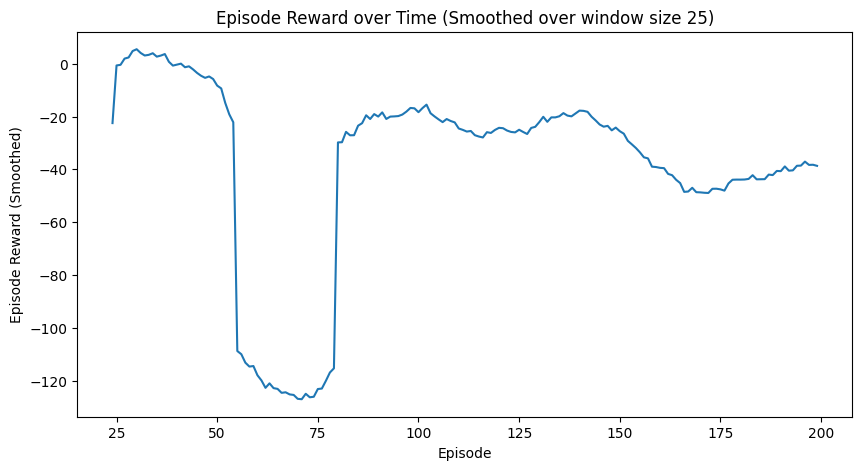

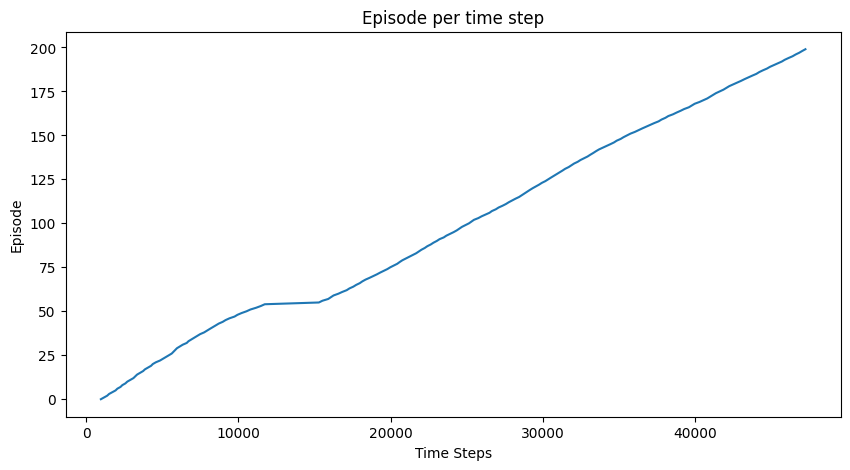

-------------------------------
| V_dbe |  58.137274650970085  |
-------------------------------

############################################################################
Starting epoch 0 .... 
Alpha_vec value at the start of the epoch = [-0.6110275   0.96090328  0.27444385  0.65464446 -0.54417831  0.22657379
  0.4035276   0.59970366 -0.59093717  0.77183592  0.64940425 -0.08421463
 -0.58583441 -0.37701535 -0.30296147 -0.7728647   0.91103136  0.85177588
  0.40415365 -0.89076107 -0.01804672 -0.88841731 -0.31666092  0.96085172
  0.31011928 -0.01056733  0.83946016  0.72317059  0.99973906 -0.90236129
  0.64502055  0.37530838 -0.37330272  0.23464807 -0.03343216  0.35293516
 -0.02514123  0.44814551 -0.90459175 -0.43070376 -0.89439736 -0.06503649
 -0.67261296 -0.99189463 -0.05104322  0.33242124  0.01293635 -0.03059213
 -0.63614147  0.86954373]
New policy value based on previous alpha, V_vec[np] = 47.9644104460576
_____________________________LP starts_______________________________
nP_best

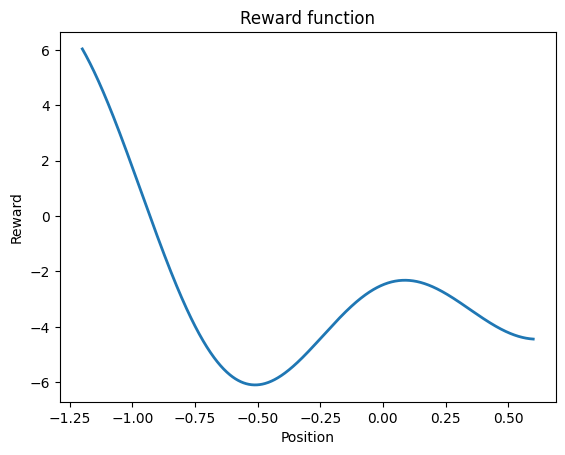

Q learning starts..........


100%|██████████| 20/20 [00:46<00:00,  2.33s/it]


############################################################################
############################################################################
Starting epoch 1 .... 
Alpha_vec value at the start of the epoch = [-1. -1.  1.  1.  1. -1.  1. -1. -1.  1. -1. -1.  1. -1. -1.  1.  1. -1.
  1. -1.  1. -1.  1.  1.  1. -1. -1. -1. -1.  1. -1. -1.  1. -1. -1.  1.
  1. -1. -1.  1.  1.  1. -1.  1. -1. -1.  1.  1. -1.  1.]
New policy value based on previous alpha, V_vec[np] = -868.2873893445752
_____________________________LP starts_______________________________
nP_best = 1
nP_best_value based on old alpha = -868.2873893445752
DBE_value based on old alpha = -768.2840222067215
**********LP results******************************************************
                       
new alpha_vec =  [-1. -1. -1.  1.  1. -1.  1. -1. -1.  1. -1. -1. -1. -1. -1.  1. -1. -1.
  1. -1.  1. -1.  1. -1.  1.  1. -1.  1. -1.  1. -1. -1.  1. -1. -1.  1.
  1. -1.  1.  1.  1. -1. -1.  1. -1.  1.  1.  1. -1.  

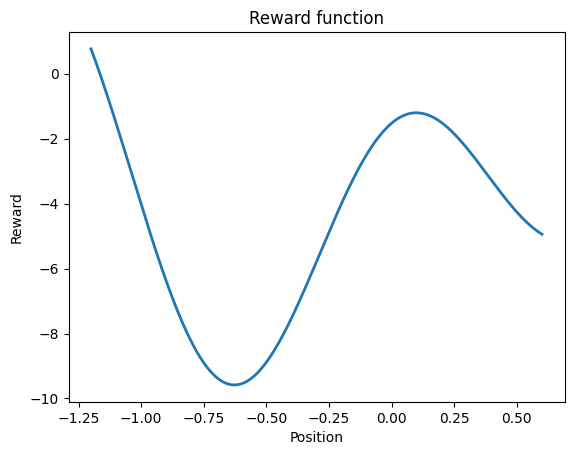

Q learning starts..........


100%|██████████| 20/20 [00:54<00:00,  2.71s/it]


############################################################################
############################################################################
Starting epoch 2 .... 
Alpha_vec value at the start of the epoch = [-1. -1. -1.  1.  1. -1.  1. -1. -1.  1. -1. -1. -1. -1. -1.  1. -1. -1.
  1. -1.  1. -1.  1. -1.  1.  1. -1.  1. -1.  1. -1. -1.  1. -1. -1.  1.
  1. -1.  1.  1.  1. -1. -1.  1. -1.  1.  1.  1. -1.  1.]
New policy value based on previous alpha, V_vec[np] = -1779.3492764824184
_____________________________LP starts_______________________________
nP_best = 1
nP_best_value based on old alpha = -1703.4972642028322
DBE_value based on old alpha = -1465.0959299980298
**********LP results******************************************************
                       
new alpha_vec =  [-1. -1. -1.  1.  1. -1.  1. -1. -1.  1. -1.  1. -1. -1. -1.  1. -1. -1.
  1. -1. -1. -1. -1. -1.  1.  1. -1.  1. -1. -1.  1. -1.  1. -1.  1.  1.
 -1. -1.  1. -1. -1. -1. -1.  1. -1.  1.  1.  1. -1

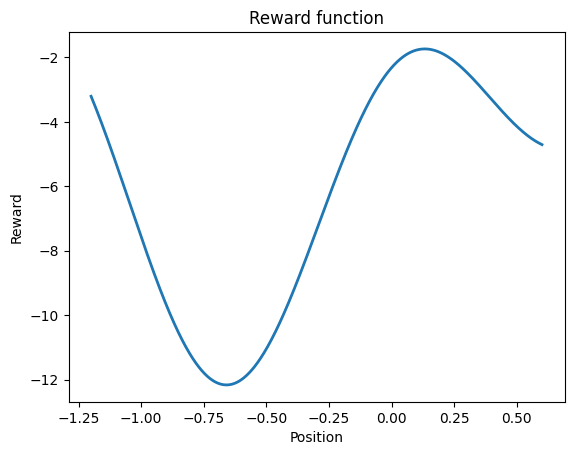

Q learning starts..........


100%|██████████| 20/20 [00:50<00:00,  2.50s/it]


############################################################################
############################################################################
Starting epoch 3 .... 
Alpha_vec value at the start of the epoch = [-1. -1. -1.  1.  1. -1.  1. -1. -1.  1. -1.  1. -1. -1. -1.  1. -1. -1.
  1. -1. -1. -1. -1. -1.  1.  1. -1.  1. -1. -1.  1. -1.  1. -1.  1.  1.
 -1. -1.  1. -1. -1. -1. -1.  1. -1.  1.  1.  1. -1.  1.]
New policy value based on previous alpha, V_vec[np] = -1729.7092323522106
_____________________________LP starts_______________________________
nP_best = 3
nP_best_value based on old alpha = -1729.7092323522106
DBE_value based on old alpha = -1961.9882949426988
**********LP results******************************************************
                       
new alpha_vec =  [ 1. -1. -1. -1.  1. -1.  1.  1. -1.  1.  1.  1. -1.  1.  1.  1. -1. -1.
  1. -1. -1.  1. -1. -1. -1.  1. -1.  1.  1. -1.  1.  1. -1. -1.  1.  1.
 -1.  1.  1. -1. -1. -1.  1. -1. -1.  1. -1. -1.  1

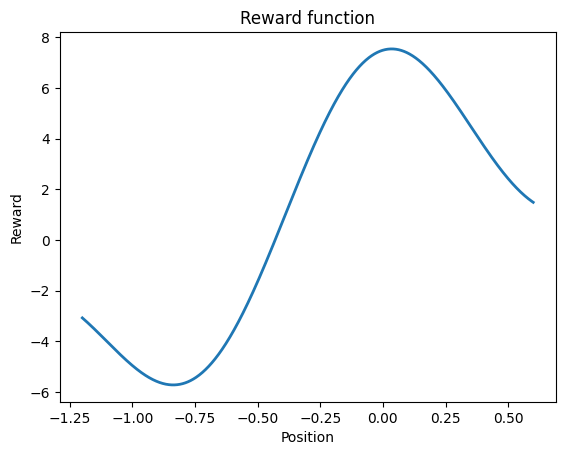

Q learning starts..........


100%|██████████| 20/20 [00:51<00:00,  2.56s/it]


############################################################################
############################################################################
Starting epoch 4 .... 
Alpha_vec value at the start of the epoch = [ 1. -1. -1. -1.  1. -1.  1.  1. -1.  1.  1.  1. -1.  1.  1.  1. -1. -1.
  1. -1. -1.  1. -1. -1. -1.  1. -1.  1.  1. -1.  1.  1. -1. -1.  1.  1.
 -1.  1.  1. -1. -1. -1.  1. -1. -1.  1. -1. -1.  1. -1.]
New policy value based on previous alpha, V_vec[np] = -598.3406787774404
_____________________________LP starts_______________________________
nP_best = 3
nP_best_value based on old alpha = -364.890033073813
DBE_value based on old alpha = -448.91670925295864
**********LP results******************************************************
                       
new alpha_vec =  [ 1. -1. -1. -1.  1. -1.  1.  1. -1.  1.  1.  1. -1.  1.  1.  1. -1. -1.
  1. -1. -1.  1. -1. -1. -1.  1.  1.  1.  1. -1.  1.  1. -1. -1.  1. -1.
 -1.  1.  1. -1. -1. -1.  1. -1. -1.  1. -1. -1.  1. -

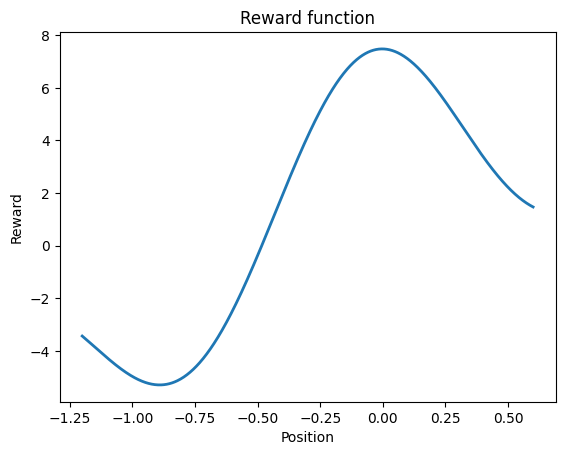

Q learning starts..........


100%|██████████| 20/20 [00:44<00:00,  2.23s/it]


############################################################################
############################################################################
Starting epoch 5 .... 
Alpha_vec value at the start of the epoch = [ 1. -1. -1. -1.  1. -1.  1.  1. -1.  1.  1.  1. -1.  1.  1.  1. -1. -1.
  1. -1. -1.  1. -1. -1. -1.  1.  1.  1.  1. -1.  1.  1. -1. -1.  1. -1.
 -1.  1.  1. -1. -1. -1.  1. -1. -1.  1. -1. -1.  1. -1.]
New policy value based on previous alpha, V_vec[np] = -192.73458116598675
_____________________________LP starts_______________________________
nP_best = 0
nP_best_value based on old alpha = -175.89789459677746
DBE_value based on old alpha = -276.04369614884195
**********LP results******************************************************
                       
new alpha_vec =  [ 1.  1. -1. -1. -1.  1.  1.  1. -1.  1.  1.  1. -1.  1.  1.  1. -1.  1.
 -1.  1. -1.  1. -1. -1. -1.  1.  1.  1.  1. -1.  1.  1. -1.  1.  1. -1.
 -1.  1.  1. -1. -1. -1.  1. -1.  1.  1. -1. -1.  1

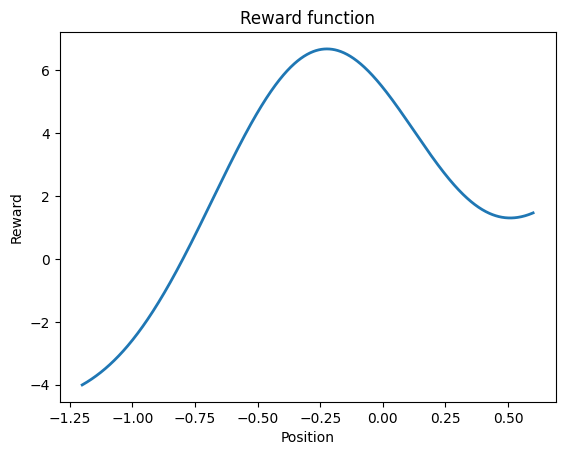

Q learning starts..........


100%|██████████| 20/20 [00:49<00:00,  2.46s/it]


############################################################################
############################################################################
Starting epoch 6 .... 
Alpha_vec value at the start of the epoch = [ 1.  1. -1. -1. -1.  1.  1.  1. -1.  1.  1.  1. -1.  1.  1.  1. -1.  1.
 -1.  1. -1.  1. -1. -1. -1.  1.  1.  1.  1. -1.  1.  1. -1.  1.  1. -1.
 -1.  1.  1. -1. -1. -1.  1. -1.  1.  1. -1. -1.  1. -1.]
New policy value based on previous alpha, V_vec[np] = 382.8602657462056
_____________________________LP starts_______________________________
nP_best = 0
nP_best_value based on old alpha = 848.2663675506546
DBE_value based on old alpha = 537.9682469909371
**********LP results******************************************************
                       
new alpha_vec =  [ 1.  1. -1. -1. -1.  1.  1.  1.  1.  1.  1.  1. -1.  1.  1.  1. -1.  1.
 -1.  1. -1.  1. -1. -1. -1.  1.  1.  1.  1. -1.  1.  1. -1.  1.  1. -1.
 -1.  1.  1. -1. -1. -1.  1. -1.  1.  1. -1. -1.  1. -1.]

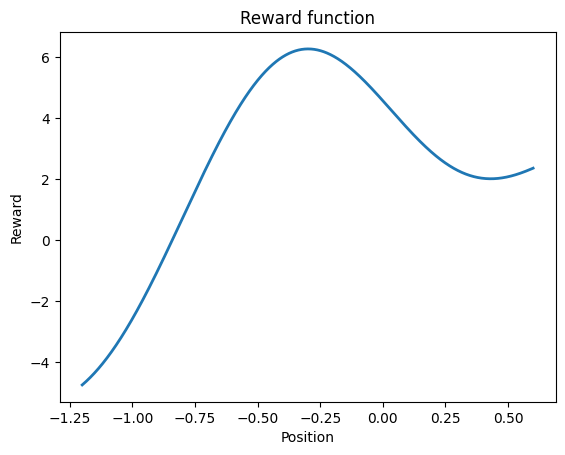

Q learning starts..........


100%|██████████| 20/20 [00:45<00:00,  2.25s/it]


############################################################################
############################################################################
Starting epoch 7 .... 
Alpha_vec value at the start of the epoch = [ 1.  1. -1. -1. -1.  1.  1.  1.  1.  1.  1.  1. -1.  1.  1.  1. -1.  1.
 -1.  1. -1.  1. -1. -1. -1.  1.  1.  1.  1. -1.  1.  1. -1.  1.  1. -1.
 -1.  1.  1. -1. -1. -1.  1. -1.  1.  1. -1. -1.  1. -1.]
New policy value based on previous alpha, V_vec[np] = 429.6393766847966
_____________________________LP starts_______________________________
nP_best = 0
nP_best_value based on old alpha = 974.2255949248225
DBE_value based on old alpha = 612.4899307992242
**********LP results******************************************************
                       
new alpha_vec =  [ 1.  1. -1. -1. -1.  1.  1.  1.  1.  1.  1. -1. -1.  1.  1.  1.  1.  1.
 -1.  1.  1.  1.  1.  1. -1.  1.  1. -1.  1. -1. -1.  1. -1.  1. -1. -1.
  1.  1. -1.  1.  1.  1.  1. -1.  1. -1. -1. -1.  1. -1.]

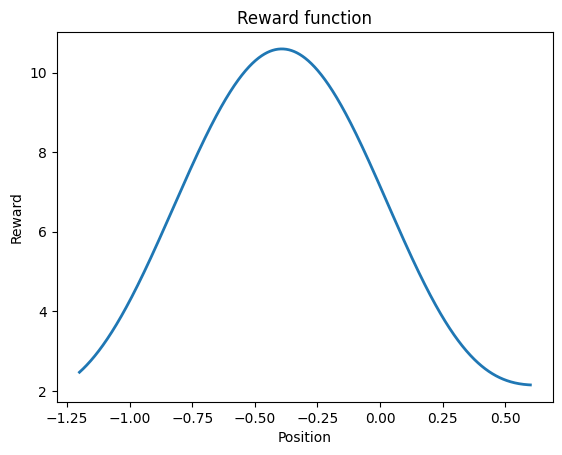

Q learning starts..........


100%|██████████| 20/20 [00:41<00:00,  2.08s/it]


############################################################################
############################################################################
Starting epoch 8 .... 
Alpha_vec value at the start of the epoch = [ 1.  1. -1. -1. -1.  1.  1.  1.  1.  1.  1. -1. -1.  1.  1.  1.  1.  1.
 -1.  1.  1.  1.  1.  1. -1.  1.  1. -1.  1. -1. -1.  1. -1.  1. -1. -1.
  1.  1. -1.  1.  1.  1.  1. -1.  1. -1. -1. -1.  1. -1.]
New policy value based on previous alpha, V_vec[np] = 1509.0495733776265
_____________________________LP starts_______________________________
nP_best = 0
nP_best_value based on old alpha = 2002.2489418275215
DBE_value based on old alpha = 1701.3538176125853
**********LP results******************************************************
                       
new alpha_vec =  [ 1.  1. -1. -1. -1.  1.  1.  1.  1. -1.  1. -1. -1.  1.  1.  1.  1.  1.
 -1.  1.  1.  1.  1.  1. -1.  1.  1. -1.  1. -1. -1.  1. -1.  1. -1. -1.
  1.  1. -1.  1.  1.  1.  1. -1.  1. -1. -1. -1.  1. -

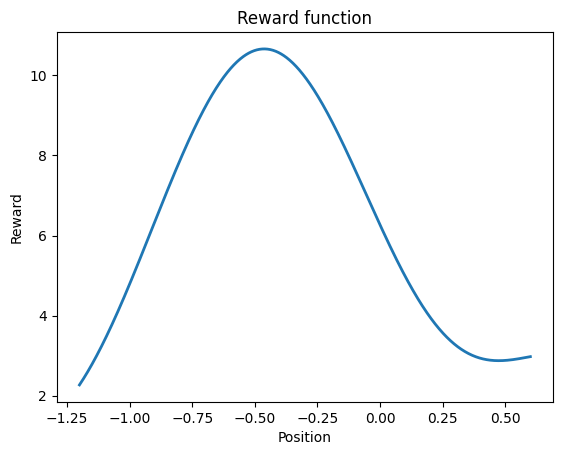

Q learning starts..........


100%|██████████| 20/20 [00:47<00:00,  2.38s/it]


############################################################################
############################################################################
Starting epoch 9 .... 
Alpha_vec value at the start of the epoch = [ 1.  1. -1. -1. -1.  1.  1.  1.  1. -1.  1. -1. -1.  1.  1.  1.  1.  1.
 -1.  1.  1.  1.  1.  1. -1.  1.  1. -1.  1. -1. -1.  1. -1.  1. -1. -1.
  1.  1. -1.  1.  1.  1.  1. -1.  1. -1. -1. -1.  1. -1.]
New policy value based on previous alpha, V_vec[np] = 1474.2009201698822
_____________________________LP starts_______________________________
nP_best = 0
nP_best_value based on old alpha = 2083.8243808550583
DBE_value based on old alpha = 1771.9360736687686
**********LP results******************************************************
                       
new alpha_vec =  [ 1.  1.  1. -1. -1.  1. -1.  1.  1. -1.  1. -1. -1.  1.  1.  1.  1.  1.
 -1.  1.  1.  1.  1.  1. -1.  1.  1. -1.  1. -1. -1. -1. -1.  1. -1. -1.
  1.  1. -1.  1.  1.  1.  1. -1.  1. -1. -1. -1.  1. -

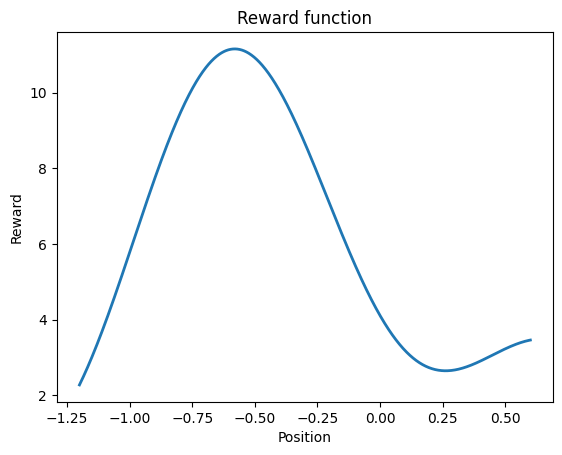

Q learning starts..........


100%|██████████| 20/20 [00:57<00:00,  2.89s/it]


############################################################################
############################################################################
Starting epoch 10 .... 
Alpha_vec value at the start of the epoch = [ 1.  1.  1. -1. -1.  1. -1.  1.  1. -1.  1. -1. -1.  1.  1.  1.  1.  1.
 -1.  1.  1.  1.  1.  1. -1.  1.  1. -1.  1. -1. -1. -1. -1.  1. -1. -1.
  1.  1. -1.  1.  1.  1.  1. -1.  1. -1. -1. -1.  1. -1.]
New policy value based on previous alpha, V_vec[np] = 1965.2599573736798
_____________________________LP starts_______________________________
nP_best = 0
nP_best_value based on old alpha = 2178.2092874160744
DBE_value based on old alpha = 1855.5002378007352
**********LP results******************************************************
                       
new alpha_vec =  [ 1.  1. -1. -1. -1.  1.  1.  1.  1.  1.  1. -1. -1.  1.  1.  1.  1.  1.
 -1.  1.  1.  1.  1.  1. -1.  1.  1. -1.  1. -1. -1.  1. -1.  1. -1. -1.
  1.  1. -1.  1.  1.  1.  1. -1.  1. -1. -1. -1.  1. 

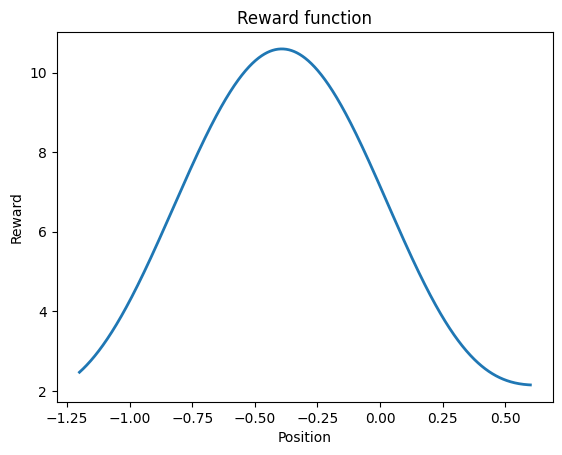

Q learning starts..........


100%|██████████| 20/20 [00:43<00:00,  2.20s/it]


In [15]:
"""
Central Code Block.
"""
# Defining Gym Environment
env = gym.make("MountainCar-v0").env  
reset_environment(env)
# Global_variables
featureVecDim= 50        #In 2000 paper, 26 was used.  #global_variable


# Creating observation set of the state values
observation_examples= np.array([env.observation_space.sample() for x in range(10000)])

# Normalizes state variable values. 
scaler = normalization(env, observation_examples)
normalized_data = scaler.fit_transform(observation_examples)

# Reward Basis functions Container/ Feature vector Container 
featurizer_vector = featurizer_function(normalized_data, featureVecDim)

# Defining Alpha_vec α=[α0 α1 ... αn]
alpha_vec = RandomVectorGenerator(featureVecDim)  
print("Random Alpha Vector: ")
print(alpha_vec)

# Running Q-learning code
print('\n'+'____Expert Policy Generation____'+'\n')
print("** For printing iterations with number of timesteps it took, set {print_ep_lens=True}.Highly Suggested for starting analysis.")
featurizer = state_featurizer(normalized_data)
policy_dbe, estimator_dbe = policy_f(env,scaler,featurizer,print_ep_lens=False) 

# IRL Main Code
reward_fn, alpha_vec = irl(env, alpha_vec, featurizer_vector,scaler,featurizer,
                           normalized_data,featureVecDim, policy_dbe)


Plot saved as mountain_car_2024-12-18_18-06-43.png


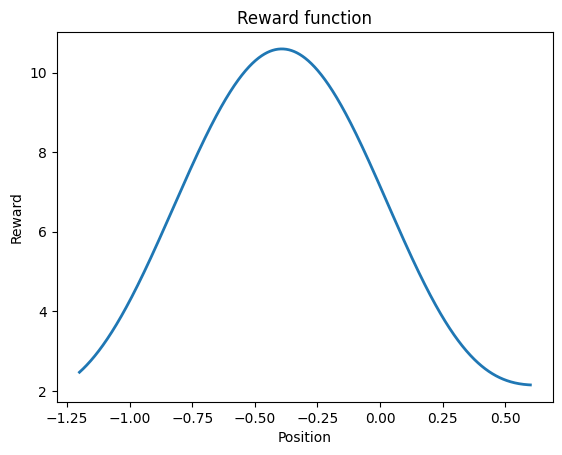

Q-learning starts:


  0%|          | 1/200 [01:18<4:20:38, 78.59s/it]


KeyboardInterrupt: 

: 

In [16]:
"""
Code Block generating stats for agent trained through learnt reward function.
"""
estimator_f = Estimator(env, scaler, featurizer)
reward_plot(alpha_vec,featurizer_vector,scaler, save=True)
print("Q-learning starts:")
"""
** For printing iterations with number of timesteps required, set {print_ep_details=True} in q_learning_testing_rewards().
Highly Suggested for starting analysis.
"""
success = q_learning_testing_rewards(env, estimator_f, reward_fn , num_episodes=200,ep_details=False)

print("Final results in graphs and 3D visualization:")
plotting.plot_cost_to_go_mountain_car(env, estimator_f)
plotting.plot_episode_stats(success, smoothing_window=25)

In [ ]:
a,b = compare_results(env,estimator_f,estimator_dbe,num_test_trajs=100,epsilon_test=0.0)